# Generating Segmentation With Pre Trained LodeStar + iDISF
---
In this notebook we demonstrate the detection of cells on the FoxP3+ dataset using a pre-trained [LodeSTAR]("https://www.nature.com/articles/s41467-022-35004-y") model. 


## Initial Setup

In [1]:
%matplotlib inline

imports

In [2]:
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import io
import os
import datetime

from PIL import Image


/home/gustavo/.local/lib/python3.10/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/home/gustavo/.local/lib/python3.10/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2024-02-21 21:40:40.884572: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-21 21:40:41.329195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 21:40:41.329951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 21:40:41.458929: E external/l

Auxiliar funtions

In [3]:
def get_detection_image(image, detections):
    """ Returns the detections overlaping the image. """
    fig = plt.figure(figsize=(16,16))
    plt.axis('off')
    fig.tight_layout()
    
    plt.imshow(image)
    plt.scatter(detections[:, 1], detections[:, 0], color="r")

    plt.tight_layout()

    buffer = io.BytesIO()

    plt.savefig(buffer, bbox_inches='tight', pad_inches=0.0)

    buffer.seek(0)
    image_pil = Image.open(buffer)

    fig.clf()
    return image_pil

In [4]:
def get_activation_image(weights):
    """ Transforms the activation map into an image"""
    # Creates a separate figure
    fig = plt.figure(figsize=(16,16))
    plt.axis('off')
    fig.tight_layout()
    im = plt.imshow(weights.squeeze(0),cmap="gray")
    cbar = plt.colorbar(im)
    cbar.remove()

    # Automatically adjusts margins to fill the figure
    plt.tight_layout()

    # Creates a buffer to save the chart without displaying it
    buffer = io.BytesIO()

    # Saves the chart in an image
    plt.savefig(buffer, bbox_inches='tight', pad_inches=0.0)

    # Creates a PIL Image from the buffer
    buffer.seek(0)
    image_pil = Image.open(buffer)
    fig.clf()
    
    return image_pil

In [5]:
def visualize(figsize=(15, 15),**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
def crop_image(gt, crop_size):
    left = 0
    top = 0
    right =  gt.size[0] - crop_size
    bottom =  gt.size[1] - crop_size
    cropped = gt.crop((left, top, right, bottom))
    return cropped

In [7]:
RESULT_FOLDER = f'../data/Output/{datetime.datetime.now()}'
def save_results(original_imgs, activations, detections, gt_imgs):  
    """ Saves all of the predicionts to the output folder """ 
    if not os.path.exists(RESULT_FOLDER):
        os.makedirs(RESULT_FOLDER)
        os.makedirs(f'{RESULT_FOLDER}/activations')
        os.makedirs(f'{RESULT_FOLDER}/detections')
        os.makedirs(f'{RESULT_FOLDER}/original')
        os.makedirs(f'{RESULT_FOLDER}/cropped_gt')
        
    for i in range(len(original_imgs)):
            activations[i].save(f'{RESULT_FOLDER}/activations/{i+1}.jpg')
            detections[i].save(f'{RESULT_FOLDER}/detections/{i+1}.jpg')
            original_imgs[i].save(f'{RESULT_FOLDER}/original/{i+1}.jpg')
            gt_imgs[i].save(f'{RESULT_FOLDER}/cropped_gt/{i+1}.jpg')

In [8]:
def make_predictions(model, alpha, cutoff, save = False):
    """ Given the detection hyperparams returns the predictions"""
    # Creating the output lists
    detections = []
    original_imgs = []
    gt_imgs = []
    activations = []

    for i in range(1,11):
        # reading the images
        input_img = dt.LoadImage(f"../data/CellsDataset/original/{i}.jpg")()._value / 256
        gt = Image.open(f"../data/CellsDataset/ground_truth/{i}.png")
        original_img = Image.open(f"../data/CellsDataset/original/{i}.jpg")

        # cropping the image
        input_img = input_img[:-400, :-400]
        gt_img = crop_image(gt, 400)
        original_img = crop_image(original_img, 400)

        # obtaining the predictions
        _,weights = model.predict(input_img[np.newaxis])
        detection = model.predict_and_detect(input_img[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]
        
        # Transforming the predictions into images
        detection_img = get_detection_image(input_img, detection)
        activation_img = get_activation_image(weights)


        activations.append(activation_img.resize(gt_img.size).convert('RGB'))
        detections.append(detection_img.resize(gt_img.size).convert('RGB'))
        gt_imgs.append(gt_img)
        original_imgs.append(original_img)
        
    if(save):
        save_results(original_imgs, activations, detections, gt_imgs)
    return activations, detections, original_imgs, gt_imgs

In [9]:
def load_model(checkpoint_path):
    """ Loads the pre-trained model """
    loaded = dt.models.LodeSTAR(input_shape=(None, None, 3))
    loaded.build(input_shape=())
    loaded.load_weights(checkpoint_path)
    return loaded

Loading The model

In [10]:
model = load_model('../checkpoints/best.h5')
print(type(model))

<class 'deeptrack.models.lodestar.models.LodeSTAR'>


Generating the predictions

In [63]:
activations, detections, original_imgs, gt_imgs = make_predictions(model, alpha = 0.5, cutoff = 0.999, save=False)

1/1 [==============================] - 2s 2s/step


<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

Visualizing the results

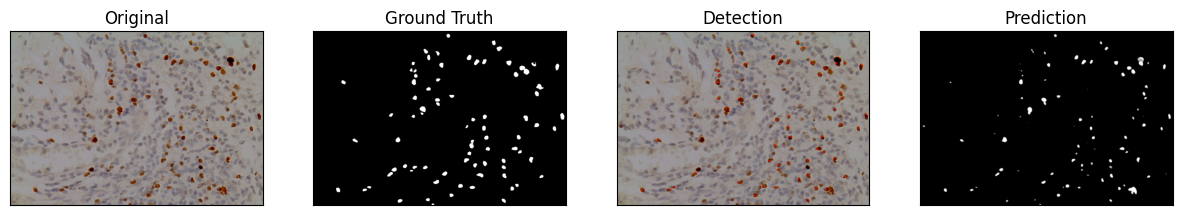

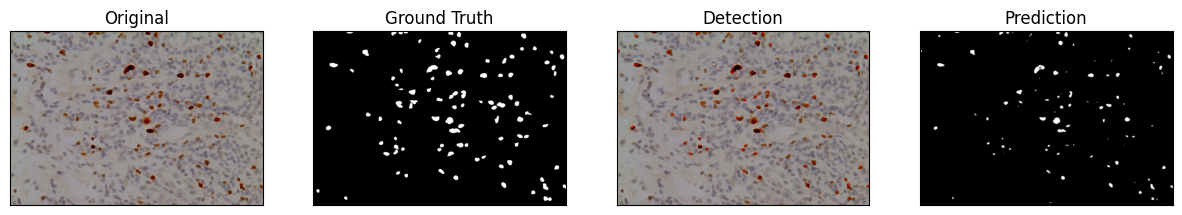

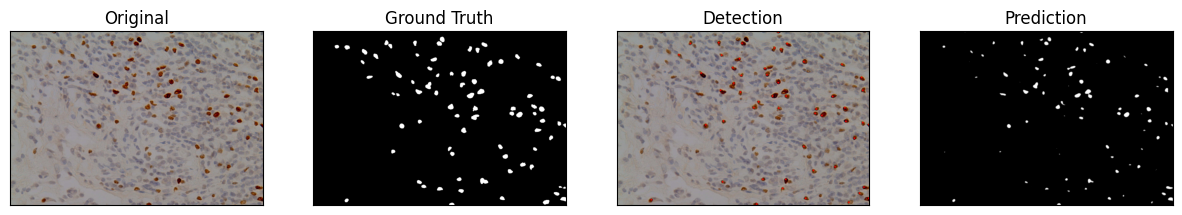

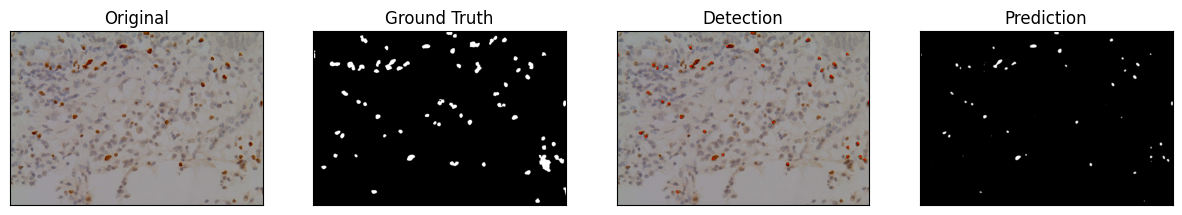

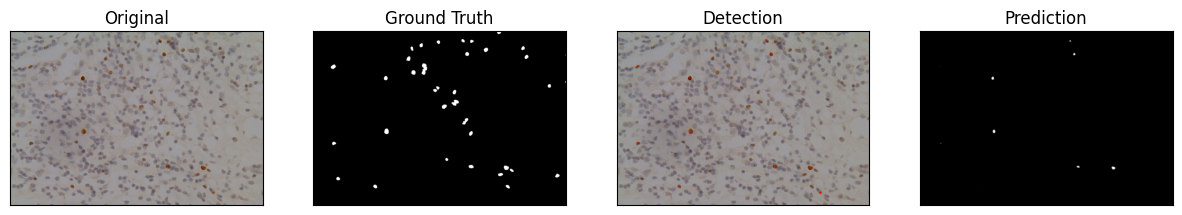

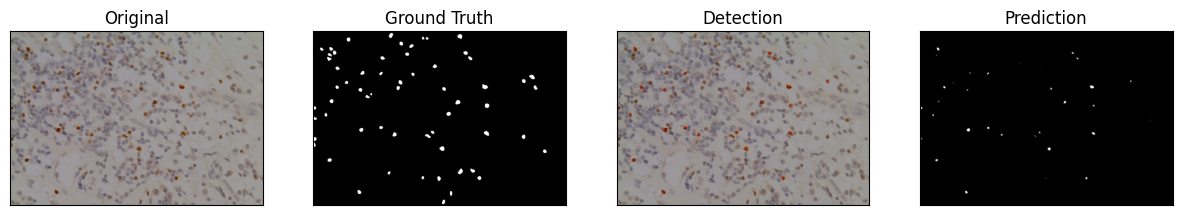

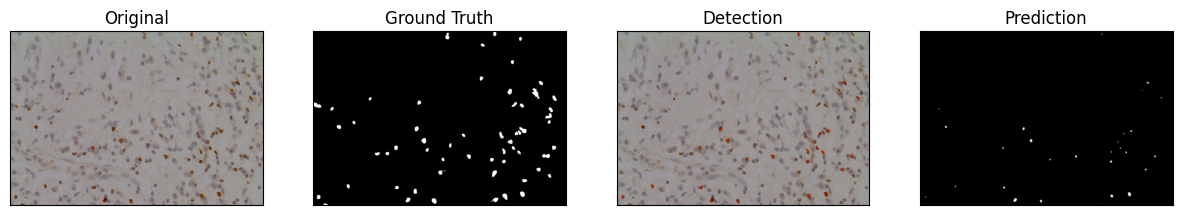

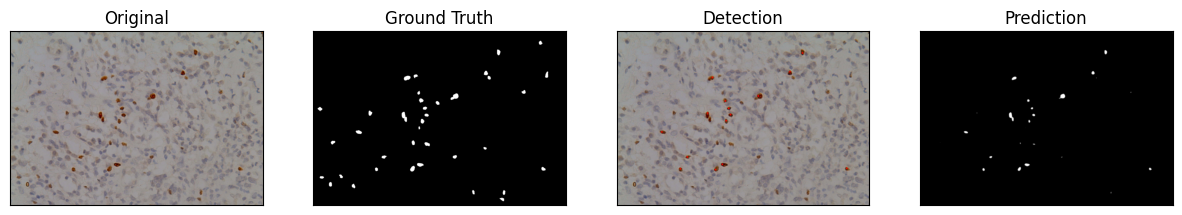

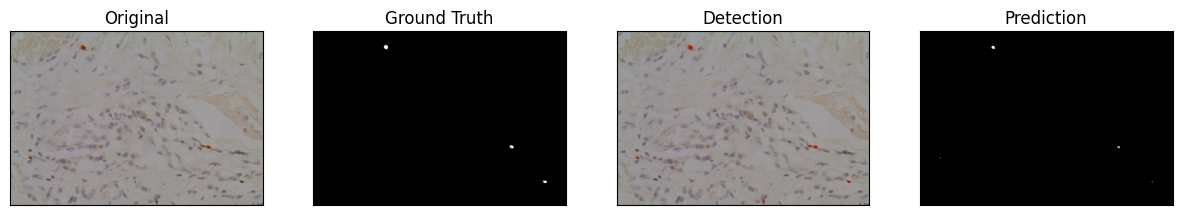

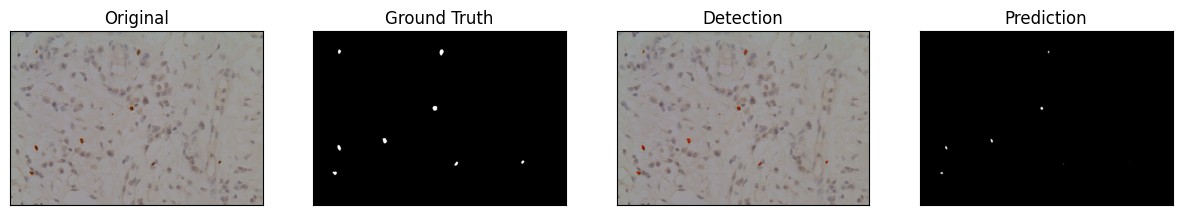

In [64]:
for index in range(len(detections)):
    visualize(original = original_imgs[index], ground_truth = gt_imgs[index], detection = detections[index], prediction = activations[index])

# Quantitative Evaluation
After generating all of the predictions we evaluate the model qualitatively and quantitatively.

In [65]:
total_of_images = len(activations)

### Mean IoU

Computing the mean Intersection Over Union (IOU) metric given by the following equation:
$$
 MeanIoU =\frac{1}{N}\sum_{i=1}^{N} \frac{A_i \cap B_i}{A_i \cup B_i}
$$

In [66]:
def calculate_iou(image1, image2):
    """ Computes the Intersection Over Union metric"""
    intersection = np.logical_and(image1, image2)
    union = np.logical_or(image1, image2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [67]:
mean_iou = sum([calculate_iou(gt_imgs[i], activations[i]) for i in range(total_of_images)]) / total_of_images
print(f'Mean IoU: {round(mean_iou, 2)}')

Mean IoU: 0.43


### Mean Dice Coheficient
Computing the mean dice Coheficient metric, given by the following equation:
$$
  Mean \space Dice = \frac{1}{N}\sum_{i=1}^{N} \frac{2 \times |A_i \cap B_i|}{|A_i|+|B_i|}
$$

In [68]:
def calculate_dice(image1, image2):
    """ Computes the Dice Coheficient metric"""
    np_1 = np.asarray(image1)
    np_2 = np.asarray(image2)
    intersection = np.sum(np_1 & np_2)
    sum = abs(np.sum(image1)) + abs(np.sum(image2))
    dice = (2. * intersection) / sum 
    return dice

In [69]:
mean_dice = sum([calculate_dice(gt_imgs[i], activations[i]) for i in range(total_of_images)]) / total_of_images
print(f'Mean Dice: {round(mean_dice, 2)}')

Mean Dice: 0.38


### F1-Score
Computing the F1-Score given by the following equation:
$$F1 Score = \frac{2 \cdot Precision \cdot Recall}{Recall + Recall}$$

The precision can be computed by:
$$Precision = \frac{TP}{TP + FP}$$

And the recall can be computed by:
$$Recall = \frac{TP}{TP + FN}$$

## Qualitative Evaluation

In [70]:
def overlay_comparison(pred, gt):
    """ Creates an overlapped visualization 
    bewtween the ground truth and the obtained prediction"""
    pred_arr = np.asarray(pred)
    gt_arr = np.asarray(gt)

    binary_xor = cv2.bitwise_xor(pred_arr, gt_arr)
    return Image.fromarray(binary_xor)

Visualizing the results

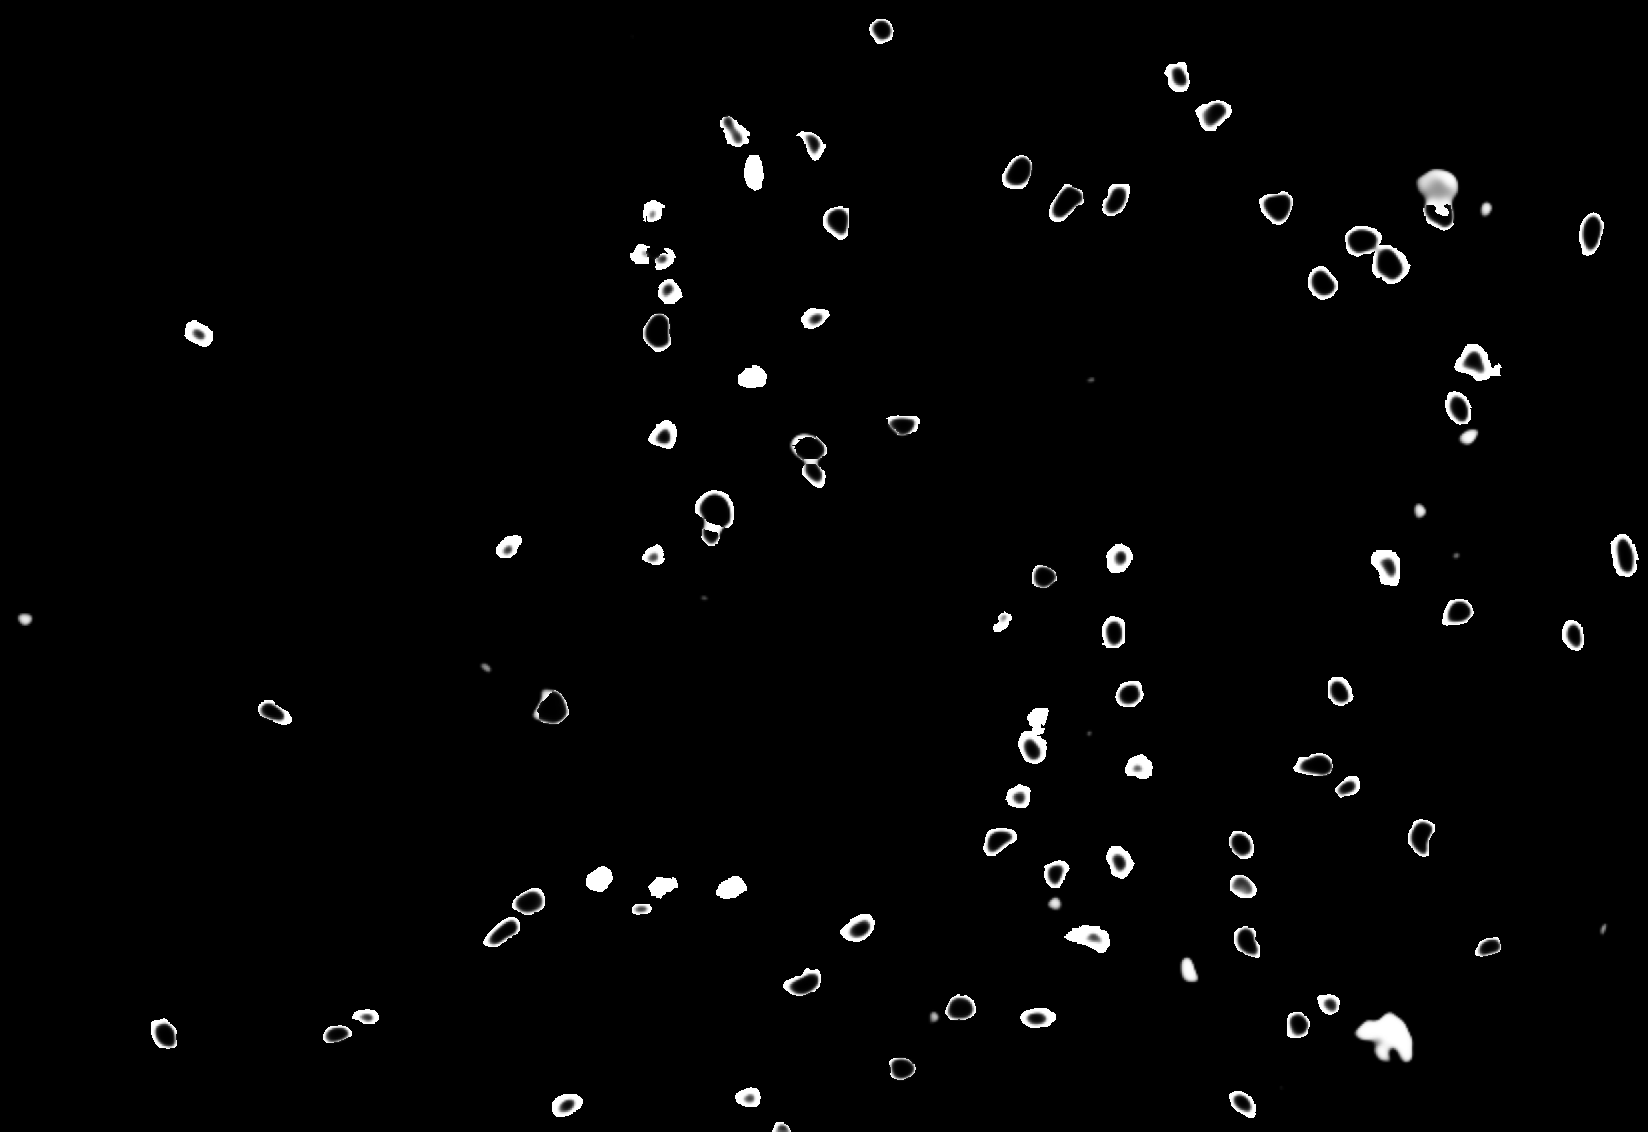

In [71]:
overlay_comparison(activations[0], gt_imgs[0])